<a href="https://colab.research.google.com/github/nbrunella19/CIINTI/blob/main/INTI_RA_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/INTI.svg/1200px-INTI.svg.png" width="100" alt="10">
Bienvenido a la aplicación para análisis de medición de resistencia eléctrica del departamento de patrones cuánticos de INTI.

La funcionalidad del software es tomar los archivos recibidos desde la aplicación del 6010SW Software versión 1.8.4 junto a las mediciones de temperatura, mostrar y determinar los resultados.

Programación de funciones __2024__: [Nicolás Brunella](mailto:nbrunella@inti.gob.ar)

Colaboración y modificaciones __2024__: [Mariano Real](mailto:mreal@inti.gob.ar)

Cálculos de mediciones de Rosemount __1999__: [Ricardo Iuzzolino](riuzzolino@inti.gob.ar)

# Inicialización


## Librerias

In [1]:
import io
import glob
import os
import sys
import re
import traceback
import cmath
import copy
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
from io import StringIO
from datetime import datetime
from google.colab import files
from IPython.display import FileLink
from IPython.display import display, HTML
from IPython.display import clear_output

## Variables Globales

In [2]:
flag_lmea=0
flag_ldat=0
flag_control=0
flag_En_Calc=0
flag_En_Graf=0
flag_Ch_Drop=0
flag_del=0

num_measure_est=10                # Valor default de valores para estadística
num_measure_est_str='10'
num_measure_aux=20

Sonda_name= "LPC PT100-02"
Sonda = 1
Standar_1  = [1.00001472,-0.00000007,-0.000000034,23.0]  #Ro,alfa,beta,To
Standar_100= [100.000157,0.00000004,-0.000000026,23.0]

Rs_R0=100.000157
Rs_alpha=0.00000004
Rs_beta=-0.000000026
Rs_T=23.0
Rs_Un=0.12 #En ppm

index=1

delList=[]
deleted_Amount=0



## Funciones Generales

In [3]:
def counter_different_values(lista):
    '''
    Cuenta las diferentes corrientes de medición que se realizaron
    Input: Lista
    Output: int
    '''
    different_values = set(lista)
    different_quantity = len(different_values)
    return different_quantity


In [4]:
def solve_quadratic(a, b, c):
    '''
    Esta ecuación resuelve la cuadrática asumiendo que
    ax**2+bx+c=0
    input: coeficientes reales
    output: raices
    '''
    # Calculate the discriminant
    discriminant = cmath.sqrt(b**2 - 4*a*c)

    # Calculate the solutions
    root1 = (-b + discriminant) / (2*a)
    root2 = (-b - discriminant) / (2*a)

    root1 = root1.real if abs(root1.imag) < 1e-10 else float('nan')
    root2 = root2.real if abs(root2.imag) < 1e-10 else float('nan')

    return float(root1), float(root2)

In [5]:
def openFile(path2file):
    '''
    Abre el archivo, devuelve las líneas del archivo path2file.
    Asume que el archivo es un .mea
    Input= path
    output = lineas de un archivo (strings)
    '''
    try:
        with open(path2file, mode='r') as f:  # to ensure it closes correclty
            lines = f.readlines()
            return lines
    except Exception as exception:
        print("There was a problem opening {}".format(path2file))
        print(exception)
        raise

In [6]:
def openFile_T(path2file):
    '''
    Abre el archivo, devuelve las líneas del archivo path2file.
    Asume que el archivo es un .dat
    Input= path
    output = lineas de un archivo (strings)
    '''
    try:
        with open(path2file, mode='r', encoding='utf-8', errors='ignore') as g:  # to ensure it closes correclty
            lines = g.readlines()
            return lines
    except Exception as exception:
        print("There was a problem opening {}".format(path2file))
        print(exception)
        raise

In [7]:
def read_mea_file(lines_of_mea_file, ln_preface = 81):
    '''
    Esta función toma lo que se obtuvo de openFile, lo troza y ordena en listas
    Inputs:
        lines_of_mea_file: Lista de lineas de string obtenidas de openFile()
        ln_preface(optional, default=  81): Número de lineas a saltear donde empiezan los datos de medición.
    Outputs:
        qlistInit: Lista que contiene todos los datos técnicos de la medición
        qlist: Lista que contiene las mediciones. Por ej. lista[2]= Medición 3
        qlistFinal: Lista que contiene un resumen de la medición y fecha de realización
    Para el porceso es recomendable que todos los archivos estén juntos en el mismo archivo.
    Notar que no importa si las mediciones tienes diferentes cantidad de puntos.
    '''
    chunks = []
    qlist = []
    chunksInit =[]
    qlistInit = []
    chunksFinal = []
    qlistFinal = []
    nn = 0
    Quantity_Measurements = 0
    ii = 0
    for line in lines_of_mea_file:
        if (nn>ln_preface and line != '\n' and ii == 0):
            chunks.append(line)
            nn += 1
        elif (nn<ln_preface):
            chunksInit.append(line)
            nn +=1
        elif (nn>ln_preface and line == '\n'):
            ii = 1
            nn += 1
        elif (nn>ln_preface and ii == 1 and line != '***\n'):
            chunksFinal.append(line)
            nn += 1
        elif (line =='***\n'):
            ii = 0
            Quantity_Measurements += 1
            nn = 0
            qlist.append(chunks)
            qlistInit.append(chunksInit)
            qlistFinal.append(chunksFinal)
            chunks = []
            chunksInit = []
            chunksFinal = []
        else:
            nn += 1
    return qlistInit, qlist, qlistFinal,Quantity_Measurements

In [8]:
def select_arch_dat():
    '''
    Función para seleccionar un archivo
    Input: nada
    Output: FileLink/Path
    '''
    file_path_i=''
    uploaded = files.upload()                   # Muestra un cuadro de diálogo para cargar un archivo

    ruta_al_archivo = list(uploaded.keys())[0]  # Obtiene la ruta del archivo cargado

    _, extension = os.path.splitext(ruta_al_archivo)
    if extension.lower() == '.dat':
      file_path_i = FileLink(ruta_al_archivo)     # Crea un enlace para abrir el archivo
    else:
      file_path_i=''

    return (file_path_i)                        # Muestra el enlace

In [9]:
def select_arch_mea():
    '''
    Función para seleccionar un archivo
    Input: nada
    Output: FileLink/Path
    '''
    file_path_i=''
    uploaded = files.upload()                   # Muestra un cuadro de diálogo para cargar un archivo

    ruta_al_archivo = list(uploaded.keys())[0]  # Obtiene la ruta del archivo cargado

    _, extension = os.path.splitext(ruta_al_archivo)
    if extension.lower() == '.mea':
      file_path_i = FileLink(ruta_al_archivo)     # Crea un enlace para abrir el archivo
    else:
      file_path_i=''

    return (file_path_i)                        # Muestra el enlace

In [10]:
def get_Date_num(Date_aux):
  '''
  Toma una linea de texto en con la fecha y horaria y devuelve
  un string con la fecha expresada en dd/mm/aaaa y un valor numerico representativo
  '''
  Date_1=Date_aux.split()
  Date=Date_1[0]
  Time=Date_1[1]

  Date_s=Date.split("/")
  Day=Date_s[0]
  Mon=Date_s[1]
  Yea=Date_s[2]

  Time_s=Time.split(":")
  Hour=Time_s[0]
  Minu=Time_s[1]
  Seco=Time_s[2]

  auxday=int(Day)
  auxmon=int(Mon)
  if auxday<10:
    Day="0"+Day
  if auxmon<10:
    Mon="0"+Mon

  Date_num=int(Yea+Mon+Day+Hour+Minu+Seco)

  return Date,Date_num,Time


In [11]:
#Acá armo un "Base de datos" con los nombres y valores de las sondas

datos_Rosemoun= [100,0.004,-7.5*10**(-7)]                                   # (Valores inventados de esta porque falta poner el método adecuado)
datos_PT10002= [99.942247,0.0039253221,-7.5009932*10**(-7)]
SondaList=['STRP Rosemount','LPC PT100-02','STRP Rosemount y LPC PT100-02']

SDic = {SondaList[0]: datos_Rosemoun, SondaList[1]: datos_PT10002}
Files = ['R_0', 'Alpha', 'Beta']
df_s = pd.DataFrame(SDic, index=Files)


In [12]:
def validar_texto(texto):
    Quantity=0
    # Verificar si el texto es un único carácter numérico
    if texto.isdigit():
        Quantity=1
        return int(texto),Quantity

    # Verificar si el texto son varios caracteres numéricos separados por ","
    numeros = texto.split(",")
    numeros_validos = [num.strip() for num in numeros if num.strip().isdigit()]

    if len(numeros_validos) > 0:
        Quantity=len(numeros_validos)
        return [int(num) for num in numeros_validos],Quantity

    # Si no se cumple ninguna condición, imprimir mensaje de error
    print("El texto ingresado no es válido:", texto)
    return None,Quantity

## Funciones para menú de configuración

In [13]:
checkpoint = widgets.Checkbox(value=False, description='Rx fue seteado como Rs?')
gamma_inv= False

def save_checkpoint(change):
    global gamma_inv
    if change['new']:
        gamma_inv=checkpoint.value
    else:
        gamma_inv=False


checkpoint.observe(save_checkpoint, 'value')


In [14]:
# Crear widgets
button_mea = widgets.Button(description="Seleccionar *.mea")
button_dat = widgets.Button(description="Seleccionar  *.dat")
button_est_ok = widgets.Button(description="Cargar")
button_reset =  widgets.Button(description="Reset")
input_text_est = widgets.Text(value= str(num_measure_est), description='Muestras:')

input_text_K   = widgets.Text(value= '', description='K para 95%:')
input_text_erc = widgets.Text(value= '', description='Error DVM:')
input_text_ur0 = widgets.Text(value= '', description='UR0 PT100:')

Sonda_dropdown= widgets.Dropdown(
    options= SondaList,
    value=SondaList[Sonda],
    description='Sonda:')

def handle_dropdown_Sonda(change):
    global Sonda,Sonda_name
    Sonda_name = change.new
    if(Sonda_name=='STRP Rosemount'): Sonda=0
    if(Sonda_name=='LPC PT100-02'): Sonda=1
    if(Sonda_name=='STRP Rosemount y LPC PT100-02'): Sonda=2


Sonda_dropdown.observe(handle_dropdown_Sonda, names='value')

def on_button_mea_click(b):                      #Carga de .mea
    global flag_lmea,file_path
    if(flag_lmea==0):
      file_path= str(select_arch_mea())
      if file_path=='':
        Ejecutar_para_configurar()
        flag_lmea=1

def on_button_dat_click(b):                      #Carga de .dat
    global flag_ldat,file_path_t
    if(flag_ldat==0):
      file_path_t= str(select_arch_dat())
      if file_path_t=='':
        Ejecutar_para_configurar()
        flag_ldat=1

def on_button_reset1(b):
  global flag_lmea,flag_ldat,file_path,file_path_t,flag_control
  Ejecutar_para_configurar()
  if(flag_control==0):
    flag_lmea=0
    flag_ldat=0
  else:
    file_path   ==''
    file_path_t ==''

def on_button_set1(b):
  '''
  Esta función se encarga de mostrar en limpio todo lo que fue seteado
  '''
  global num_measure_est,num_measure_est_str,file_path_t,file_path,Sonda_name,gamma_inv,flag_control

  num_measure_aux=(input_text_est.value).strip()
  clear_output()
  if (flag_lmea==1) or(flag_ldat==1) or(num_measure_aux.isdigit()==False):
      if flag_lmea==1:
            display("El archivo seleccionado no tiene extención *.mea")
      if flag_ldat==1:
            display("El archivo seleccionado no tiene extención *.dat")
      if num_measure_aux.isdigit()==False:
            flag_control=1
            display("El valor introducido de muestras no es numérico")
      else:
        num_measure_est=int(num_measure_aux)                                    #Convierto el valor numérico tomado para operar
        num_measure_est_str=num_measure_aux                                     #Copio el valor auxiliar dinámico a una variable para imprimirlo

  else:
        num_measure_est=int(num_measure_aux)
        num_measure_est_str=num_measure_aux                                     #Copio el valor auxiliar dinámico a una variable para imprimirlo
        display("Archivo seleccionado de medición de resistencia: "+file_path)
        display("Archivo seleccionado de medición de temperatura: "+file_path_t)
        display("Número de muestras para estadística: "+num_measure_aux)
        display("Sensor de Temperatura: "+Sonda_name)
        if gamma_inv==True:
          display("Rx fue conectada como patrón")
        else:
          display("Rs fue conectada como patrón")
  display(button_reset)
  flag_control=0                                          #Para saber si el error de carga fue por una introducción errones de caracteres

# Configurar la función a llamar cuando se hace clic en el botón
button_mea.on_click(on_button_mea_click)
button_dat.on_click(on_button_dat_click)
button_est_ok.on_click(on_button_set1)
button_reset.on_click(on_button_reset1)

def Ejecutar_para_configurar():
    clear_output()
    display(button_mea)
    display(button_dat)
    display(input_text_est)
    display(Sonda_dropdown)
    display(checkpoint)
    """
    display(input_text_K)
    display(input_text_erc)
    display(input_text_ur0)
    """
    display(button_est_ok)


#Menú de configuración


In [15]:
Ejecutar_para_configurar()

'Archivo seleccionado de medición de resistencia: /content/ELT50 vs Fluke100.mea'

'Archivo seleccionado de medición de temperatura: /content/ELT50 vs Fluke100.DAT'

'Número de muestras para estadística: 25'

'Sensor de Temperatura: LPC PT100-02'

'Rs fue conectada como patrón'

Button(description='Reset', style=ButtonStyle())

# Ejecutar para análisis de archivos

## Análisis de archivo de medición: *.mea

In [16]:
lineas = openFile(file_path)
qlistInit_aux, qlist_aux, qlistFinal_aux,Quantity_Measurements_aux= read_mea_file(lineas, ln_preface = 81)


In [17]:
                                                              #Esta celda está para arreglar si hay una medición trunca
qlistFinal=[]
qlistInit=[]
qlist=[]


for i in range(Quantity_Measurements_aux):                      # Solo mediciones buenas proporcionan 12 líneas en qListFinal_aux
  if len(qlistFinal_aux[i])==12:
      qlistInit.append(qlistInit_aux[i])
      qlist.append(qlist_aux[i])
      qlistFinal.append(qlistFinal_aux[i])

if flag_del==1:
    if deleted_Amount==1:
      del qlistInit[delList]
      del qlist[delList]
      del qlistFinal[delList]
    else:
      for j in range(deleted_Amount):
        del qlistInit[delList[j]]
        del qlist[delList[j]]
        del qlistFinal[delList[j]]
    flag_del=0

Quantity_Measurements=len(qlist)                                # Variable muy importante


In [18]:
def create_df_from_list(qlist, n,num_measure_est):
    '''
    Crea un DataFrame desde una lista proveniente del .mea
    Input: listado,número a iterar
    Output: Dataframe
    '''
    df_aux = pd.DataFrame([sub.split(';') for sub in qlist[n]])
    size_df_m=df_aux.shape[0]
    if size_df_m<num_measure_est:                                     # Si el número es mayor que el medido se toma toda el largo de la medición
      num_measure_est=size_df_m
    df = df_aux.tail(num_measure_est)                                 # Recorta la lista a num_measure_est de largo
    df.columns = ['Ratio', 'Measure', 'Time']
    return df


In [19]:
df_m = [create_df_from_list(qlist, i,num_measure_est) for i in range(Quantity_Measurements)]          # Crea una lista de Dataframe

for i in range(Quantity_Measurements):
    df_m[i]['Time'] = df_m[i]['Time'].str.strip()

In [20]:
measure_f=[]                                                            #Lista de mediciones en formato float
time_h=[]                                                               #Lista de hora en formato "H":"M":"S"
ratio=[]
for i in range(Quantity_Measurements):                                                # Genero un listado de listas del tipo float
      measure_f.append([float(numero) for numero in df_m[i]["Measure"]])
      ratio.append([float(numero) for numero in df_m[i]["Ratio"]])
      time_h.append(df_m[i]["Time"])

In [21]:
#Listados de los parámetros de las mediciones para operar
iList=[0]*Quantity_Measurements               #Listado de corrientes
RsList=[0]*Quantity_Measurements              #Listado de patrones
RxList=[0]*Quantity_Measurements              #Listado de Mesurandos
MvList=[0]*Quantity_Measurements              #Listado de Mediciones medias
StList=[0]*Quantity_Measurements              #Listado de desvios
StartDateList=[0]*Quantity_Measurements       #Listado de fecha de inicio
StartDateNumList=[0]*Quantity_Measurements    #Listado de fecha y horario de inicio formato entero
StopDateList=[0]*Quantity_Measurements        #Listado de fecha de finalización
StopDateNumList=[0]*Quantity_Measurements     #Listado de fecha y horario de finalización formato entero
StartHourList=[0]*Quantity_Measurements       #Listado de horario de inicio
StopHourList=[0]*Quantity_Measurements        #Listado de horario de finalización
Rs_modelList=[0]*Quantity_Measurements        #Listado de resistencia seteada como patrón
Rx_modelList=[0]*Quantity_Measurements        #Listado de resistencia seteada como mesurando
Hum_List=[0]*Quantity_Measurements            #Listado de humedad ambiente
Ug_List=[0]*Quantity_Measurements             #Listado de humedad ambiente


for i in range(Quantity_Measurements):
  StartDate_aux= qlistInit[i][13].strip()
  StartDateList[i],StartDateNumList[i],StartHourList[i]= get_Date_num(StartDate_aux)  # Obtengo un valor tipo string para presentar y otro int para operar
  StopDate_aux= qlistFinal[i][11].strip()
  StopDateList[i],StopDateNumList[i],StopHourList[i]=get_Date_num(StopDate_aux)       #Idem

  Hum_List[i]=qlistInit[i][16].strip()              #Línea donde se guarda la humedad ambiente
  iList[i]   =qlistInit[i][22].strip()              #Línea donde se guarda la corriente Rx
  RsList[i]  =qlistInit[i][33].strip()              #Línea donde se guarda la que valor nominal de patrón se usó
  Rs_modelList[i]=qlistInit[i][39].strip()          #Línea donde se guarda el modelo del patrón
  RxList[i]      =qlistInit[i][57].strip()          #Línea donde se guarda la que valor nominal de patrón se usó
  Rx_modelList[i]=qlistInit[i][64].strip()          #Línea donde se guarda el modelo del resistor a medir
  Ug_List[i]=float(qlistFinal[i][1].strip())        #Incertidumbre de gamma (Uγ) en ppm



In [22]:
#Esta parte  de la sección resuelve si el patrón fue seleccionado como mesurando y viceversa

amList=[0]*Quantity_Measurements
gammaList=[0]*Quantity_Measurements

for i in range(Quantity_Measurements):
  ratio_aux=np.mean(ratio[i])
  if(gamma_inv==False):
    # Valor promedio de gamma (Rx/Rs) medido por medición
    gammaList[i]=ratio_aux
  else:
    # Valor promedio de gamma inverso (Rs/Rx) medido por medición
    gammaList[i]=1/ratio_aux


In [23]:
# Esta parte de la sección resuelve el cálculo de la humedad ambiente
Hum_FList=[]
Hum_SList=[]

for i in range(Quantity_Measurements):
  if Hum_List[i]=='':
    Hum_SList.append("No se ha medido humedad")
  else:
    Hum_float=float(Hum_List[i])
    if Hum_float>30:
      Hum_FList.append(Hum_float)
      Hum_SList.append(Hum_List[i])
    else:
      Hum_SList.append("No se ha medido humedad")

Humidity_f=np.mean(Hum_FList)
Humidity_s= str(Humidity_f)


## Análisis de archivo de medición: *.dat

In [24]:
lineas_t = openFile_T(file_path_t)

In [25]:
Measures_of_datlist=[]

for line in lineas_t:                     # Lectura de .dat
  line_header= line[:6]                   # line_header detecta el encabezado
  line_sensor= line[:8]                   # line_sensor me permite saber que sonda es
  if(line_header!="sensor"):
    if ":" in line:
      Measures_of_datlist.append(line)    # Agrega a la lista la info



df_t = pd.DataFrame([linea.split(",") for linea in Measures_of_datlist], columns=['Date Hour T', 'Mean S1', 'Mean S2', 'Time T'])

size_df_t=df_t.shape[0]                   # Variable que me dice la cantidad de mediciones de temperatura que hay

for i in range(size_df_t):
    df_t['Time T'] = df_t['Time T'].str.strip()

df_t['Time T'] = df_t['Time T'].astype(int)
df_t['Mean S1'] = df_t['Mean S1'].astype(float)
df_t['Mean S2'] = df_t['Mean S2'].astype(float)


In [26]:
Val_Sonda1_Ohm=[0]*size_df_t
Val_Sonda2_Ohm=[0]*size_df_t

#Paso del df a un listado (Para más fácil acceso)
for i in range(size_df_t-1):
  Val_Sonda1_Ohm[i]=df_t.loc[i, 'Mean S1'].astype(float)          #Rosemount
  Val_Sonda2_Ohm[i]=df_t.loc[i, 'Mean S2'].astype(float)          #LPC-PT100

In [27]:
def Temp_ave (R_T,Sonda_T):
  '''
  Función que calcula temperatura promedio del listado de entrada
  Input = promedio de mediciones en Ohm
  Output= promedio de temperatura en grados centígrados
  '''
  Tfinal=0
  if(Sonda_T==0):
    SColumn='STRP Rosemount'
  if(Sonda_T==1):
    SColumn='LPC PT100-02'

  R_0 = float(df_s.iloc[0, df_s.columns.get_loc(SColumn)])
  alpha=float(df_s.iloc[1, df_s.columns.get_loc(SColumn)])
  beta =float(df_s.iloc[2, df_s.columns.get_loc(SColumn)])

  c = R_0 - R_T
  b = R_0*alpha
  a = R_0*beta

  T1,T2 = solve_quadratic(a, b, c)

  if T2>0 and T2<35:
    Tfinal= T2
  elif T1>0 and T1<35:
    Tfinal= T1
  return Tfinal

In [28]:
def calc_temp_ave_List(index_T):
  '''
  Función que calcula temperatura promedio de una medición puntual
  Input = Número de Medición
  Output= promedio de temperatura en grados centígrados
  '''
  R_Tlist_S1=[]
  R_Tlist_S2=[]
  Uta_List_S1=0
  Uta_List_S2=0

  Start_Mean= StartDateNumList[index_T]           #Tomo los extremos temporales de medición
  Stop_Mean = StopDateNumList[index_T]

#Recorriendo el listado de temperaturas compara por mayor y menor para analizar en rango
  for i in range(size_df_t):
    time_mean_temp = int(df_t.iloc[i, df_t.columns.get_loc('Time T')])
    if time_mean_temp>=Start_Mean and time_mean_temp<=Stop_Mean:
        R_Tlist_S1.append(Val_Sonda1_Ohm[i])
        R_Tlist_S2.append(Val_Sonda2_Ohm[i])

#Según que sonda fue utilizada opero con una u otra variable
  if R_Tlist_S1:
    T_aux_1=Temp_ave(np.mean(R_Tlist_S1),0)       # Temperatura promedio en el tiempo de medicion de R
    Uta_List_S1=np.std(R_Tlist_S1)                # Desvío estándar de la temperatura
  else:
    T_aux_1=0
  if R_Tlist_S2:
    T_aux_2=Temp_ave(np.mean(R_Tlist_S2),1)       # Temperatura promedio en el tiempo de medicion de R
    Uta_List_S2=np.std(R_Tlist_S2)                # Desvío estándar de la temperatura
  else:
    T_aux_2=0
  return T_aux_1,T_aux_2,Uta_List_S1,Uta_List_S2

In [29]:
'''
Inputs:
       dw_value_R: resistance value of the STRP (for now Rosemount)
       year: year of measurement, not nesesarly current year, you can use any given year since initial calibration

Output:
    temperature in Celsius

Original work for Visual Basic by
author : Ricardo J. Iuzzolino

Modify to Python by
author:  Mariano A. Real
'''

def its90(dw_value_R, R3, a):
    '''
    dw_value_R = measured STRP resistance (ohms)
    R3 = calibrated STRP triple point of water resistance (ohms)
    year = intended year of use, will select corresponding (lower) calibration year.
    eg. if calibration years are 2010 and 2016, and 2015 is the input then 2010 will be selected as calibration year.
    out = t90 value (Celcius)
    '''

    b = 0
    # Vector init
    D =[439.932854,
        472.41802,
        37.684494,
        7.472018,
        2.920828,
        0.005184,
        -0.963864,
        -0.188732,
        0.191203,
        0.049025]

    W = dw_value_R / R3
    Wr = W - a * (W - 1) - b * ((W - 1) ** 2)

    t90 = 0.0
    for ii in range(len(D)):
        t90 = t90 + D[ii] * (((Wr - 2.64) / 1.64) ** ii)

    return t90

def main(year_input, dw_value_R, calibration_data_file):
    # read calibration data from csv file
    cwd = os.getcwd() #get current directory
    os.chdir(cwd)
    sprt_cal_file= calibration_data_file

    # determine calibration year to use
    df = pd.read_csv(cwd + sprt_cal_file, sep= ';')
    last_year = df['year'].iloc[-1]

    if year_input > last_year:
        year = last_year
        idx = df.year[df.year == year].index.tolist()
    else:
        df_sort = df.iloc[(df['year']-year_input).abs().argsort()[:2]]
        year = min(df_sort['year'].tolist())
        idx = df.year[df.year == year].index.tolist()

    t90 = its90(dw_value_R,df.R3[idx[0]],df.a[idx[0]])
    print(t90)
    return t90


In [ ]:
TempList_S1=[0]*Quantity_Measurements                                  #Temp promedio por medición (Rosemount)
TempList_S2=[0]*Quantity_Measurements                                  #Temp promedio por medición (PT100)
TempListString_S1=[""]*Quantity_Measurements                           #Idem en formato string
TempListString_S2=[""]*Quantity_Measurements                           #Idem en formato string
TempListFloat_S1=[]
TempListFloat_S2=[]

UTempList_S1=[0]*Quantity_Measurements                                  #Temp promedio por medición (Rosemount)
UTempList_S2=[0]*Quantity_Measurements                                  #Temp promedio por medición (PT100)

#Genero Listas con los promedios de cada medición
for i in range(Quantity_Measurements):
  TempList_S1[i],TempList_S2[i],UTempList_S1[i],UTempList_S2[i]= calc_temp_ave_List(i)

#Si el resultado es 0 es que no se midió(En condiciones normales)
  if TempList_S1[i]==0:                                                #Si dan 0 es que la medición no fue tomada
    Temp_aux= "Temperatura no Medida"                                  #Puede existir otra condición
  else:
    TempListFloat_S1.append(TempList_S1[i])
    Temp_aux=str(round(TempList_S1[i],2))
  TempListString_S1[i]=Temp_aux

  if TempList_S2[i]==0:
    Temp_aux="Temperatura no medida"
  else:
    TempListFloat_S2.append(TempList_S2[i])
    Temp_aux=str(round(TempList_S2[i],2))
  TempListString_S2[i]=Temp_aux

Temp_ave_full_S1=np.mean(TempListFloat_S1)
Temp_ave_full_S2=np.mean(TempListFloat_S2)

uta_S1=np.mean(UTempList_S1)
uta_S2=np.mean(UTempList_S2)


In [31]:
#Listados que permiten el cálculo de la resistencia corregida por temperatura
measure_fixed_TList=[]
measure_fixed_T=[0]*Quantity_Measurements
aux_measure_fixed_T=[0]*num_measure_est

if Sonda==0:tParam =TempList_S1    #Listado de temperaturas promedio de sonda Rosemount
if Sonda==1:tParam =TempList_S2    #Listado de temperaturas promedio de sonda PT100

# Bucle que forma un listado de listas con los resultados de resistencia corregidos por temperatura
for i in range(Quantity_Measurements):
  T=tParam[i]                                                           # T= Temperatura medida
  a_sd = Rs_alpha*(T-Rs_T)                                              # α.(T-T0)
  b_sd = (Rs_beta*(T-Rs_T))**2                                          # β.(T-T0)²

  for j in range(num_measure_est):
    gamma_sd=ratio[i][j]                                                # γ
    aux_measure_fixed_T[j]= gamma_sd* Rs_R0* float((1+a_sd+b_sd))       # R=γ.R0.(1+α.(T-T0)+β.(T-T0)²)

  # Usa copy porque sino agregaba solo último listado muchas veces
  measure_fixed_TList.append(copy.deepcopy(aux_measure_fixed_T))


In [32]:
stdList_T=[0]*Quantity_Measurements                                             # Correcciones por temperaturas
stdList_T_ppm=[0]*Quantity_Measurements

for i in range(Quantity_Measurements):
    measure_fixed_T[i]=np.mean(measure_fixed_TList[i])                          # Valor resistencia promedio por medición corregida en temperatura
    stdList_T[i]=np.std(measure_fixed_TList[i])                                 # Valor de desviación promedio por medición corregida en temperatura
    stdList_T[i]=np.std(measure_fixed_TList[i])
    stdList_T_ppm[i]=str(round((stdList_T[i]/measure_fixed_T[i])*10**6,4))

am_full=np.mean(measure_fixed_T)                                                # Variable con el valor medio de toda la medición
sd_full=(np.std(measure_fixed_T)/am_full)*10**6                                 # Variable con el desvío estandar de toda la medición

am_full_str=str(round(am_full,9))
sd_full_str=str(round(sd_full,2))

t_x_full= [f"{i+1}" for i in range(Quantity_Measurements)]             # Listado con la cantidad de mediciones para luego graficar


## Cálculo de Incertidumbres

In [33]:
def Pitagoras(ca,ua,cb,ub,cc,uc,k):
  '''
  Función que recibe como argumentos las incertidumbres y coeficientes y retorna la incertidumbre combinada
  '''
  Uc=k*np.sqrt((ca*ua)**2 +(cb*ub)**2+(cc*uc)**2)
  return Uc

In [34]:
def Abs_to_ppm (Uabs,abs):
  '''
  Función que pasa de valor absoluto a ppm
  '''
  Uppm=round(((Uabs*10**6)/abs),3)
  return Uppm

In [35]:
def Ppm_to_abs (Uppm,abs):
  '''
  Función que pasa de ppm a valor absoluto
  '''
  Uabs=((Uppm)*abs)/10**6
  return Uabs

In [36]:
#Coeficientes de Incertidumbre Combinada de Resistencia
k=2                                                     #En principio(Lo asumo)

uxa= (sd_full*am_full)/10**6                            #Desvío estándar ya calculada
urp= (Rs_Un*Rs_R0)/10**6                                #Incertidumbre del patrón
ug = (np.mean(Ug_List)*am_full)/(2*10**6)               #ub del gamma

crp= am_full/Rs_R0                                      #Gamma
cg = Rs_R0                                              #Valor dado por el último informe de calibración

Uxc =Pitagoras(1,uxa,crp,urp,cg,ug,k)                   #Resultado absoluto
Uxc_ppm=round(((Uxc*10**6)/am_full),2)                  #En ppm
Uxc_ppm_str=str(Uxc_ppm)                                #En ppm en string


In [37]:
#Coeficientes de Incertidumbre Combinada de temperatura
ecr=0.011                                                       #Dadas por el manual de 34401A

if(Sonda==0):                                                   #Dependiendo de que sonda use elije listado
  uta=np.std(TempList_S1)
  ur=Ppm_to_abs(ecr,Temp_ave_full_S1)                           #Paso de ppm a absoluto
else:
  uta=np.std(TempList_S2)
  ur=Ppm_to_abs(ecr,Temp_ave_full_S2)

ur0=0.0000006

cr = 1/(Rs_alpha*Rs_R0)
cr0= am_full/(Rs_alpha*Rs_R0**2)

UdT = round(Pitagoras(1,uta,cr0,ur0,cr,ur,k),2)                 #Resultado absoluto
UdT_str=str(UdT)


In [38]:
Ulist=[0]*Quantity_Measurements                                 #Listado que guarda las incertidumbres por medición
Ulist_ppm=[0]*Quantity_Measurements
for i in range(Quantity_Measurements):
  ua=stdList_T[i]
  Ulist[i]= Pitagoras(1,ua,crp,urp,cg,ug,k)
  Ulist_ppm[i]=Abs_to_ppm(Ulist[i],am_full)


In [39]:
if Sonda==2:
          df_show = pd.DataFrame({'Medición': t_x_full,'Resistencia Media (Ω)':measure_fixed_T,'Incertidumbre(ppm)':Ulist_ppm, 'Temp. Medida con Rosemount (°C)': TempListString_S1,'Temp. Medida con LPC PT100-02 (°C)': TempListString_S2, 'Fecha de inicio' :StartDateList,'Horario de Inicio': StartHourList,'Fecha de Finalización' :StopDateList,'Horario de Finalización': StopHourList})
elif Sonda==1:
          df_show= pd.DataFrame({'Medición': t_x_full,'Resistencia Media (Ω)':measure_fixed_T,'Incertidumbre(ppm)':Ulist_ppm, 'Temp. Medida con LPC PT100-02  (°C)': TempListString_S2, 'Fecha de inicio' :StartDateList,'Horario de Inicio': StartHourList,'Fecha de Finalización' :StopDateList,'Horario de Finalización': StopHourList})
elif Sonda==0:
          df_show= pd.DataFrame({'Medición': t_x_full,'Resistencia Media (Ω)':measure_fixed_T,'Incertidumbre(ppm)':Ulist_ppm, 'Temp. Medida con Rosemount (°C)': TempListString_S1, 'Fecha de inicio' :StartDateList,'Horario de Inicio': StartHourList,'Fecha de Finalización' :StopDateList,'Horario de Finalización': StopHourList})



## Configuración de pestañas


In [40]:
##################################################################################################################################
counter_m=[]
for i in range(Quantity_Measurements):                             # Genera un listado en función de cuantas mediciones se leyeron
    counter_m.append(i+1)                                          # para que se muestre en la lista desplegable (dropdown)

menu_desplegable = widgets.Dropdown(                               # Creación widget de dropdown
    options=counter_m,
    value=counter_m[0],
    description='Medición:')


def handle_dropdown_change(change):                                # Función de cambio del dropdown
    global index
    if flag_Ch_Drop==0:
      index = change.new

input_text_del = widgets.Text(value= '', description='Medición:')
                                                                   # Crear widgets de texto
output_text0  = widgets.Label(value='')
output_text1  = widgets.Label(value='')
output_text2  = widgets.Label(value='')
output_text3  = widgets.Label(value='')
output_text4  = widgets.Label(value='')
output_text5  = widgets.Label(value='')
output_text6  = widgets.Label(value='')
output_text7  = widgets.Label(value='')
output_text8  = widgets.Label(value='')
output_text9  = widgets.Label(value ="Fecha de inicio :"       + StartDateList[0] + "  Hora: "+StartHourList[0])
output_text10 = widgets.Label(value ="Fecha de finalización :" + StopDateList[Quantity_Measurements-1] + "  Hora: "+StopHourList[Quantity_Measurements-1])
output_text11 = widgets.Label(value ="Resistor Incógnito :"    + RxList[0] + "Ω" )
output_text14 = widgets.Label(value ="Marca/Modelo :"          + Rx_modelList[0])
output_text12 = widgets.Label(value ="Resistor Patrón :"       + RsList[0] + "Ω")
output_text13 = widgets.Label(value ="Marca/Modelo :"          + Rs_modelList[0] + "Ω")
output_text15 = widgets.Label(value='')
output_text16 = widgets.Label(value='')
output_text17 = widgets.Label(value='Ingresar número de medición/es a sacar separándolos por comas. Por ejemplo: "2,7"')
output_text18 = widgets.Label(value='Luego presionar el botón y volver a ejecutar el análisis de archivos')
output_text19 = widgets.Label(value='')
output_text20 = widgets.Label(value='')

def Plotted_with_U(r_x, r_y,U):
      r_y_array = np.array(r_y, dtype=float)
      r_y_array = r_y_array - r_y_array.mean()
      plt.figure(figsize=(15, 6))
      plt.errorbar(r_x, r_y_array, yerr=U, fmt='o', capsize=5)
      plt.xlabel('Medición N')
      plt.ylabel('Valor Medio')
      plt.title('Medición con Incertidumbre')
      plt.grid(True)
      plt.show()

def Plotted_T(r_x, r_y):
      plt2.figure(figsize=(15, 6))
      plt2.xlabel('Medición N')
      plt2.ylabel('Temperatura (°C)')
      plt2.title('Medición de temperatura')
      plt2.grid(True)
      plt2.plot(r_x, r_y)
      plt2.show()

def Plotted_On(r_x, r_y):
      r_y_array = np.array(r_y, dtype=float)
      r_y_array = r_y_array - r_y_array.mean()
      plt.figure(figsize=(15, 6))
      plt.xticks(rotation=45)
      plt.xlabel('Horario')
      plt.ylabel('Resistencia Promedio')
      plt.title('Medición de Resistencia')
      plt.grid(True)
      plt.plot(r_x, r_y)
      plt.show()

def on_button_calcu_click(b):
  global flag_En_Calc,index,TempListString_S1,Sonda
  if flag_En_Calc==0:
      Show_Info1(index)
      flag_En_Calc=1

def Show_Info1(index_s):
      output_text0.value    = "Datos de la medición "           +str(index_s)
      output_text1.value    = "Resistencia Promedio: "          +str(measure_fixed_T[index_s-1]) + "Ω"
      output_text2.value    = "Desvío Estándar: "               + str(stdList_T[index_s-1])
      if(Sonda==0):
        output_text3.value  = "Temperatura media (Rosemount): " + TempListString_S1[index_s-1]  +"°C"
      if(Sonda==1):
        output_text3.value  = "Temperatura media (LPC-PT100): " + TempListString_S2[index_s-1]  +"°C"
      output_text4.value    = "Resistor Estándar (Rs): "        + RsList[index_s-1] +"Ω"
      output_text5.value    = "Valor nominal (Rx): "            + RxList[index_s-1] +"Ω"
      output_text6.value    = "Corriente Ix para ensayo: "      + iList[index_s-1]  +"A"
      display(df_m[index_s-1])

def on_button_clear_click(b):
    global index,flag_En_Calc, flag_En_Graf,flag_Ch_Drop
    output_text0.value = ''
    output_text1.value = ''
    output_text2.value = ''
    output_text3.value = ''
    output_text4.value = ''
    output_text5.value = ''
    output_text6.value = ''
    output_text7.value = ''
    output_text8.value = ''
    output_text9.value = ''
    output_text10.value = ''
    output_text15.value = ''
    output_text16.value = ''
    output_text19.value = ''
    output_text20.value = ''
    flag_En_Calc=0
    flag_En_Graf=0
    flag_Ch_Drop=0
    index=1
    menu_desplegable.value =index
    clear_output()
    display(tab)

def on_button_grafi_click(b):
    global index, flag_En_Graf
    if flag_En_Graf==0:
      Plotted_On(time_h[index-1], measure_f[index-1])
      flag_En_Graf=1

def on_button_show_full_click(b):
      global t_x_full , measure_fixed_T, am_full, sd_full,num_measure_est_str,Ulist,TempListFloat_S1,TempListFloat_S2,Sonda
      output_text7.value  = "Resistencia Promedio total: "    + am_full_str + "Ω"
      output_text8.value  = "Desvío estándar total(ppm): "    + sd_full_str
      output_text19.value = "Incertidumbre Combinada(ppm): "  + Uxc_ppm_str
      if(Sonda==0):
        output_text15.value ="Temperatura promedio: "+str(round(Temp_ave_full_S1,2)) +"°C"
      else:
        output_text15.value = "Temperatura promedio: "             +str(round(Temp_ave_full_S2,2)) +"°C"+"±"+UdT_str+"°C"
      output_text20.value   = "Muestras tomadas para estadística :"+num_measure_est_str
      output_text16.value   = "Humedad promedio (%): "             +Humidity_s
      display(df_show)
      Plotted_with_U(t_x_full, measure_fixed_T,Ulist)
      if(Sonda==0):
         Plotted_T(t_x_full, TempListFloat_S1)
      else:
          Plotted_T(t_x_full, TempListFloat_S2)


def on_button_del(b):
  '''
  Este botón lo que hace es setear los valores de medición a ser descartados
  '''
  global delList,flag_del, deleted_Amount

  del_aux,deleted_Amount=validar_texto(input_text_del.value)                    #Toma lo que haya en el input text, lo analiza y lo devuelve en int

  if del_aux is not None:                                                       # Si lo retornado no es un "None"  y lo guarda en las variables
    delList=del_aux
    flag_del=1                                                                  #Flag que va a indicar la edición en "Analisis de .mea"
    print("La medición/es descartadas fue/ron: ",delList)


def show_menu_1():
    display(output_text9)
    display(output_text10)
    display(output_text11)
    display(output_text14)
    display(output_text12)
    display(output_text13)
    display(button_show_full)
    display(output_text4)
    display(output_text5)
    display(output_text6)
    display(button_clear)
    display(output_text7)
    display(output_text8)
    display(output_text19)
    display(output_text15)
    display(output_text20)
    display(output_text16)

def show_menu_2():
    display(menu_desplegable)
    display(button_calcu)
    display(button_grafi)
    display(button_clear)
    display(output_text0)
    display(output_text1)
    display(output_text2)
    display(output_text3)
    display(output_text4)
    display(output_text5)
    display(output_text6)

def show_menu_3():
    display(input_text_del)
    display(button_del)
    display(output_text17)
    display(output_text18)


def Mostrar_Resultados():
  display(tab)

button_calcu = widgets.Button(description="Ver Listado")                           #Tab2
button_clear = widgets.Button(description="Limpiar")                            #Tab1 y Tab2
button_grafi = widgets.Button(description="Graficar")                           #Tab2
button_show_full = widgets.Button(description="Ver resultados global")          #Tab1
button_del = widgets.Button(description="Descartar")                            #Tab3

# Configurar la función a llamar cuando se hace clic en el botón
button_calcu.on_click(on_button_calcu_click)
button_clear.on_click(on_button_clear_click)
button_grafi.on_click(on_button_grafi_click)
button_show_full.on_click(on_button_show_full_click)
button_del.on_click(on_button_del)
menu_desplegable.observe(handle_dropdown_change, names='value')

################################################# Crear pestañas  ####################################################################

tab1 = widgets.Output()
tab2 = widgets.Output()
tab3 = widgets.Output()

tab = widgets.Tab(children=[tab1, tab2, tab3])

# Agregar etiquetas a las pestañas
tab.set_title(0, 'Análisis General')
tab.set_title(1, 'Análisis por Medición')# Contenido de la primera pestaña
tab.set_title(2, 'Editar Mediciones')
with tab1:
    show_menu_1()
# Contenido de la segunda pestaña
with tab2:
    show_menu_2()
with tab3:
    show_menu_3()


############################################################################################################################################


# Menú de visualización de resultados

,Medición,Resistencia Media (Ω),Incertidumbre(ppm),Temp. Medida con LPC PT100-02 (°C),Fecha de inicio,Horario de Inicio,Fecha de Finalización,Horario de Finalización
0,1,99.994353,1.360,19.91,20/2/2024,09:51:06,20/2/2024,10:00:08
1,2,99.994358,1.359,19.65,20/2/2024,10:00:08,20/2/2024,10:09:10
2,3,99.994357,1.367,19.53,20/2/2024,10:09:10,20/2/2024,10:18:12
3,4,99.994410,1.359,21.03,21/2/2024,09:25:09,21/2/2024,09:34:12
4,5,99.994404,1.359,20.96,21/2/2024,09:34:12,21/2/2024,09:43:16
5,6,99.994396,1.364,20.98,21/2/2024,09:43:16,21/2/2024,09:52:19
6,7,99.994435,1.362,20.76,22/2/2024,09:32:08,22/2/2024,09:41:11
7,8,99.994435,1.359,20.81,22/2/2024,09:41:11,22/2/2024,09:50:13
8,9,99.994437,1.358,20.67,22/2/2024,09:50:13,22/2/2024,09:59:10
9,10,99.994455,1.358,20.91,23/2/2024,09:27:24,23/2/2024,09:36:26


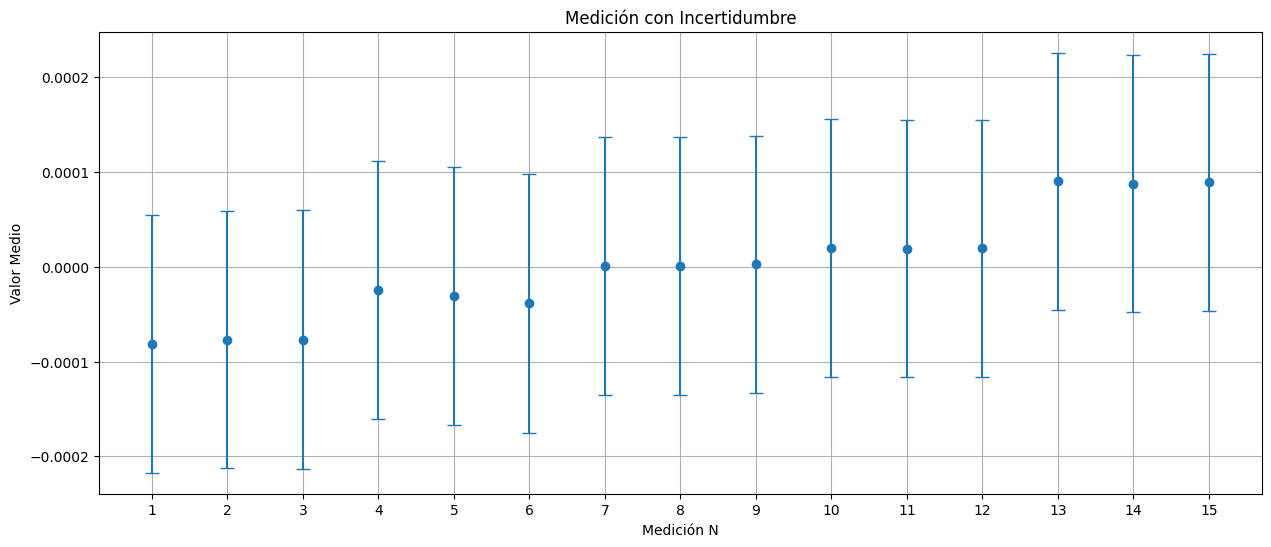

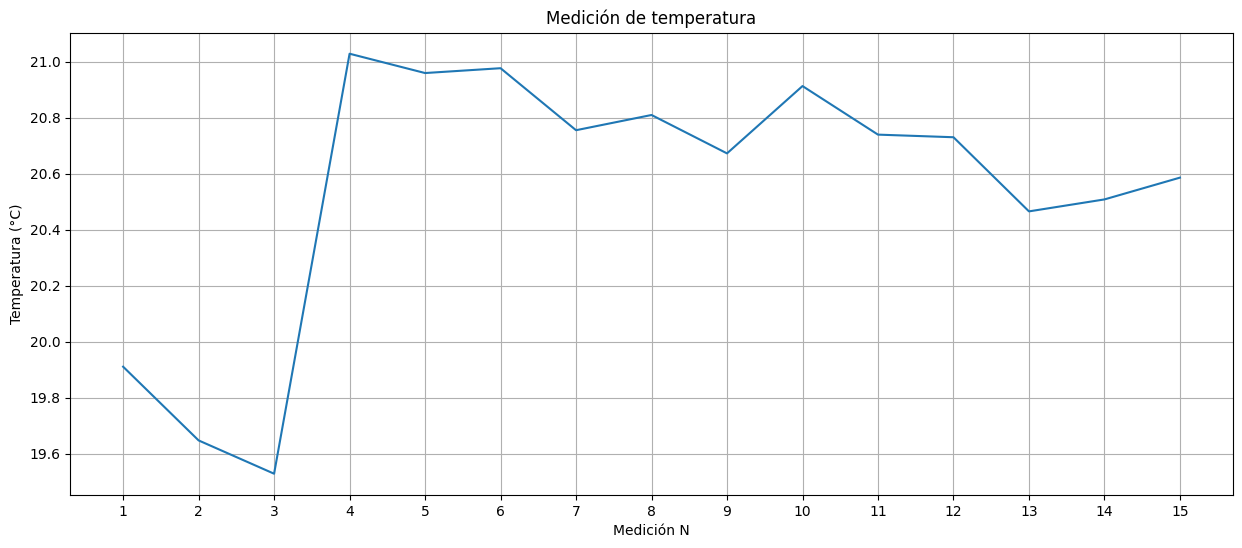

In [41]:
Mostrar_Resultados()
